## Notebook for Figure 6 and related content: Alpha cells heterogeneity and  ML for cell type classification from ephys
### Author: J. Camunas-Soler
### Last Updated: Feb. 2020

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
from singlet.dataset import Dataset
from singlet import SampleSheet, CountsTable
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
%run ./../functions/helper_functions.py

#### Load Data and definitions

In [4]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total Exocitosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [5]:
root_folder = './../data/'
analysis_folder = './../analysis/'
model_folder = analysis_folder + 'celltype_prediction_from_ephys'
fig_folder = './../figures/fig6_suppfigs6/'

In [6]:
#Load and reformat patch-seq dataset
filename =  root_folder + 'patchclamp_wcryo_human.counts.tab'
metadata = root_folder + 'patchclamp_wcryo_human.metadata.tab'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv(analysis_folder + 'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder +'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')

annotation.rename(columns=dict_phenotype_norm, inplace=True)
#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

#remove genes not seen in 5 cells or having 10 counts total
test= filter_genes_pp(test, min_cells=5, min_counts=10)
#create dataset
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
#remove nans in glucse
ds.samplesheet = ds.samplesheet[~ds.samplesheet[['Glucose_mM']].isnull().values]
#save unnormalized table
ds_pclamp_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_norm = ds.copy()
ds_norm.counts = ds_norm.counts.normalize()
ds_norm.counts.pseudocount = 1
ds_norm.counts = ds_norm.counts.log(base=2)
ds_norm.counts.pseudocount = 1
ds_norm_pclamp = ds_norm.copy()

filter_condition = {'Cryopreserved': ['Yes']}
ds_t1d = filter_samplesheet(ds_norm, filter_dict= filter_condition)

filter_condition = {'Cryopreserved': ['No']}
ds_pclamp = filter_samplesheet(ds_norm, filter_dict= filter_condition)

#### Main Fig 6 A-B

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
import scikitplot as skplt

phenotypes_N = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry', 'Early Ca2+ current','Late Ca2+ current',
                'Peak Na+ current','Na+ conductance']
'''def df_standarize(df,columns,norm=True):
    ts = df[columns]
    if norm:
        ts = (ts - ts.mean()) / ts.std()
        
    return ts'''

def filter_table_mlearn(df, columns):
    s = df.copy()
    s = s[columns]
    bad_cells = s[s.isnull().any(axis=1)].index
    s.drop(bad_cells, axis=0, inplace=True)
    return s


/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [8]:
#Dataset ND
filter_condition = {'cell_type': ['alpha','beta'],
                   'Patched':['Yes'],
                   'DiabetesStatus':['healthy']}
ds_ab = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)

#Dataset T2D
filter_condition = {'cell_type': ['alpha','beta'],
                   'Patched':['Yes'],
                   'DiabetesStatus':['T2D']}
ds_ab_T2D = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)


/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


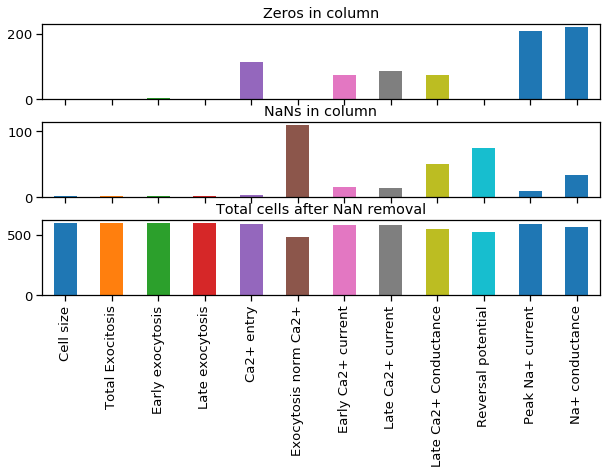

In [9]:
dataset = ds_ab.samplesheet
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
#number of zeros in dataset
fig, axs = plt.subplots(3,1, figsize=(10,5), sharex=True,gridspec_kw={'hspace': 0.3})
axs[0] = (dataset[phenotype_norm] == 0.0).sum().plot(kind='bar', ax=axs[0], title='Zeros in column')#.bar()
axs[1] = (dataset[phenotype_norm].isnull()).sum().plot(kind='bar', ax=axs[1], title='NaNs in column')#.bar()
axs[2] = (dataset[phenotype_norm]).count().plot(kind='bar', ax=axs[2], title='Total cells after NaN removal')#.bar()
fig.tight_layout()
#fig.savefig('/Users/joan/Desktop/stats_ephys.pdf')


In [10]:
dataset[phenotype_norm].isnull().sum()/dataset[phenotype_norm].count()*100

Cell size                 0.168919
Total Exocitosis          0.168919
Early exocytosis          0.168919
Late exocytosis           0.168919
Ca2+ entry                0.508475
Exocytosis norm Ca2+     22.520661
Early Ca2+ current        2.772964
Late Ca2+ current         2.417962
Late Ca2+ Conductance     9.409594
Reversal potential       14.258189
Peak Na+ current          1.541096
Na+ conductance           5.892857
dtype: float64

In [11]:
#Filter cell without all information
phenotypes_N = ['Cell size','Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry', 'Early Ca2+ current','Late Ca2+ current',
                'Peak Na+ current','Na+ conductance']

df_nd = filter_table_mlearn(ds_ab.samplesheet,phenotypes_N)
df_t2d = filter_table_mlearn(ds_ab_T2D.samplesheet,phenotypes_N)

In [12]:
#prepare ND set
X = df_nd
y = ds_ab.samplesheet.cell_type[df_nd.index]
#make train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

#prepare T2D set
X_t2d = df_t2d
y_t2d = ds_ab_T2D.samplesheet.cell_type[df_t2d.index]

In [13]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [14]:
### training of the model (time-consuming), only run if needed
# otherwise skip this cell and the following one and just load model (finalized_model.sav')
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

params = {'estimator__n_estimators': [5, 10, 15, 20, 50, 100, 200],
                 'estimator__max_depth': [2, 5, 7, 9, 15, 50],
         'estimator__max_features': ['auto', 'sqrt']}
#params = {'estimator__n_estimators': [50],
#                 'estimator__max_depth': [15]}
estimator = RandomForestClassifier(class_weight='balanced')
selector = RFECV(estimator, step=1, cv=10)
clf = GridSearchCV(selector, params, cv=10)
clf.fit(X_train, y_train)
clf.best_estimator_.estimator_

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [15]:
# save the model to disk
filename = model_folder + '/finalized_model.sav'
#joblib.dump(clf.best_estimator_, open(filename, 'wb'))

In [16]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
import scikitplot as skplt

clf.best_estimator_ = joblib.load(model_folder + '/finalized_model.sav')

Score of LR fit in train set:  1.0
Cell size             0.401375
Total Exocitosis      0.083132
Early exocytosis      0.101982
Late exocytosis       0.065286
Ca2+ entry            0.048775
Early Ca2+ current    0.056925
Late Ca2+ current     0.056309
Peak Na+ current      0.104222
Na+ conductance       0.081995
dtype: float64
Score of LR fit in test set:  0.871559633028
Score of LR fit in test T2D:  0.861111111111


<Figure size 432x288 with 0 Axes>

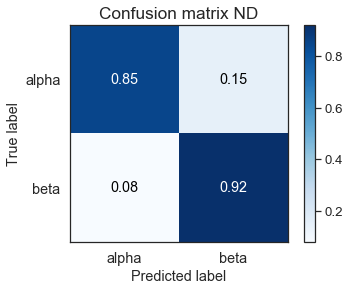

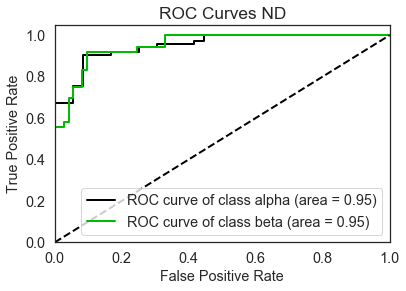

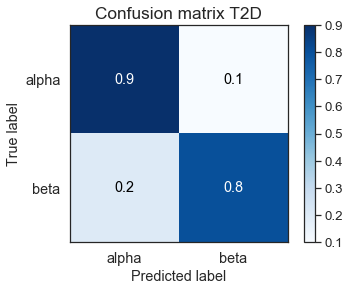

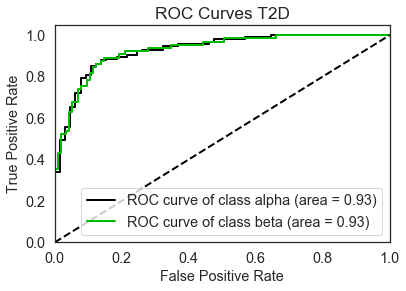

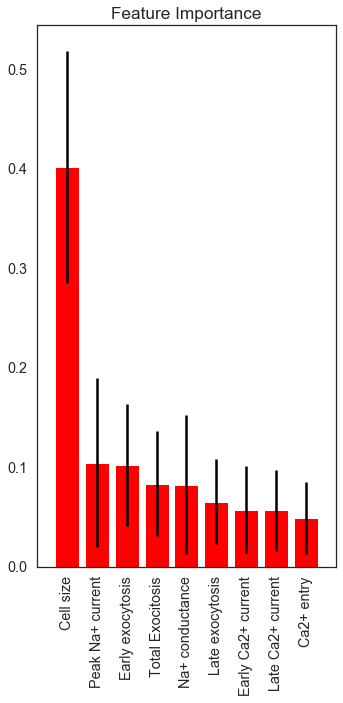

In [17]:

print("Score of LR fit in train set: ", clf.best_estimator_.score(X_train,y_train))
par_series = pd.Series(clf.best_estimator_.estimator_.feature_importances_,index=X.columns[clf.best_estimator_.support_])

print(par_series)
print("Score of LR fit in test set: ", clf.best_estimator_.score(X_test,y_test))
print("Score of LR fit in test T2D: ", clf.best_estimator_.score(X_t2d,y_t2d))


#Performance plots test set ND
sns.set_style('white')
sns.despine()
y_pred = clf.best_estimator_.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title='Confusion matrix ND')
plt.savefig(fig_folder+'fig6c_confmat_ND.pdf')
y_probas = clf.best_estimator_.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, 
                             y_probas, 
                             title='ROC Curves ND', 
                             ax=None, 
                             figsize=None, 
                       plot_micro=False,
                       plot_macro=False,
                             cmap='nipy_spectral', 
                             title_fontsize='large', 
                             text_fontsize='medium')

plt.savefig(fig_folder+'fig6a_roc_ND.pdf')
#Performance plots test set T2D
y_pred = clf.best_estimator_.predict(X_t2d)
fig2 = skplt.metrics.plot_confusion_matrix(y_t2d, y_pred, normalize=True, title='Confusion matrix T2D')
plt.savefig(fig_folder+'fig6c_confmat_T2D.pdf')
y_probas = clf.best_estimator_.predict_proba(X_t2d)
skplt.metrics.plot_roc(y_t2d, 
                             y_probas, 
                             title='ROC Curves T2D', 
                             ax=None, 
                       plot_micro=False,
                       plot_macro=False,
                             figsize=None, 
                             cmap='nipy_spectral', 
                             title_fontsize='large', 
                             text_fontsize='medium')
plt.savefig(fig_folder+'fig6a_roc_T2D.pdf')

skplt.estimators.plot_feature_importances(clf.best_estimator_.estimator_,
                                          feature_names=X.columns[clf.best_estimator_.support_],
                                          x_tick_rotation=90, figsize=(5,10))
plt.tight_layout()
plt.savefig(fig_folder+'/fig6b.pdf')

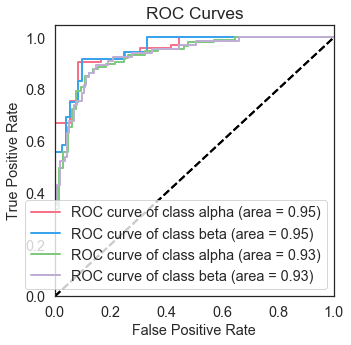

In [18]:
y_probas = clf.best_estimator_.predict_proba(X_test)

cmap1 = make_colormap_from_palette(palette_name='husl', n=3,
                              bins=2)
axs1 =skplt.metrics.plot_roc(y_test, 
                             y_probas, 
                             title='ROC Curves ND', 
                             ax=None, 
                       plot_micro=False,
                       plot_macro=False,
                             cmap=cmap1, 
                             title_fontsize='large', 
                             text_fontsize='medium',
                            figsize=(5,5))
#Performance plots test set T2D
y_pred = clf.best_estimator_.predict(X_t2d)
y_probas = clf.best_estimator_.predict_proba(X_t2d)
cmap2 = make_colormap_from_palette(palette_name='Accent', n=2,
                              bins=2)
skplt.metrics.plot_roc(y_t2d, 
                             y_probas, 
                             title='ROC Curves', 
                       plot_micro=False,
                       plot_macro=False,
                             figsize=None, 
                       ax=axs1,
                             cmap=cmap2, 
                             title_fontsize='large', 
                             text_fontsize='medium')
plt.savefig(fig_folder+'fig6a.pdf')

#### Main Figure 6 E and Supp Fig6A

In [19]:
#Read tSNE coordinates from preprocessed file and plot genes with color scale
pos_tsne = pd.read_csv(analysis_folder + 'tsne_coord_alpha.csv',
                      sep='\t',index_col=0)

filter_condition = {'cell_type': ['alpha'], 
                    'DiabetesStatus': ['healthy','T2D'],
                   'Patched': ['Yes'],#,
                   'TimefromDispersion_days': [1,2,3,4],
                   'Glucose_mM': [1,5,10]}#,
                  # 'Glucose_mM': [1,5,10]}
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)

df_tsne = pd.concat([pos_tsne, filtered_dataset.samplesheet['cell_type']],axis=1).dropna().sort_values(by='cell_type')

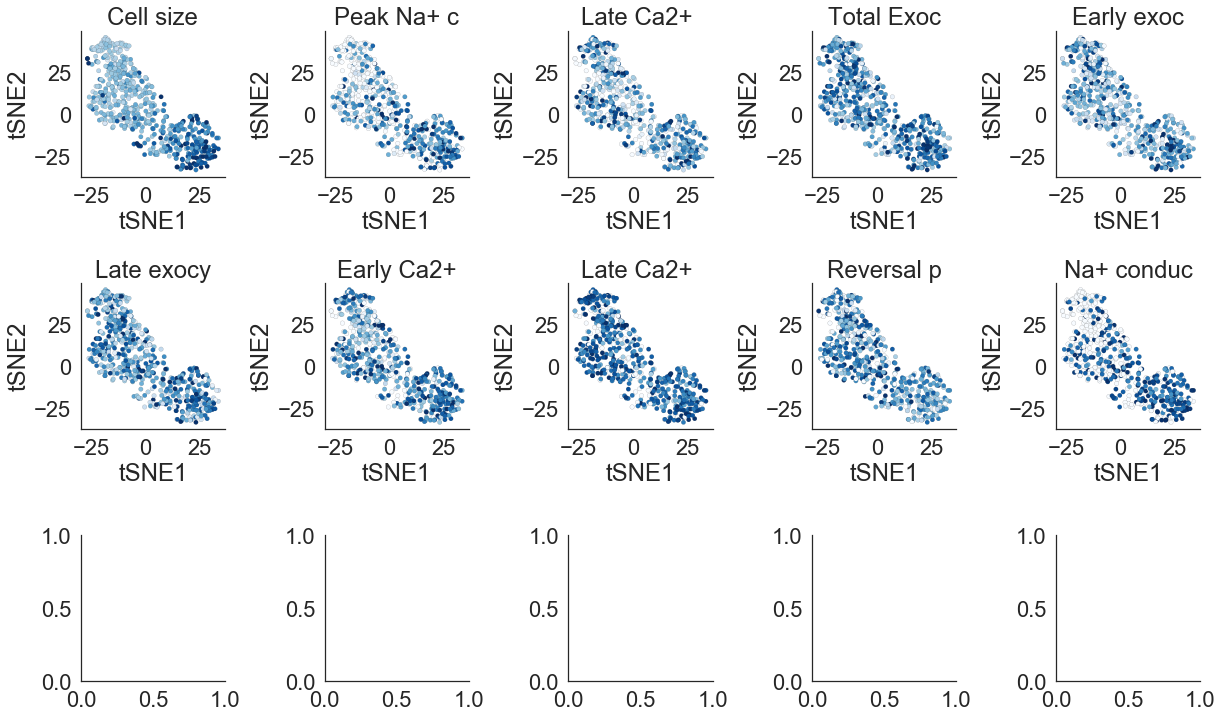

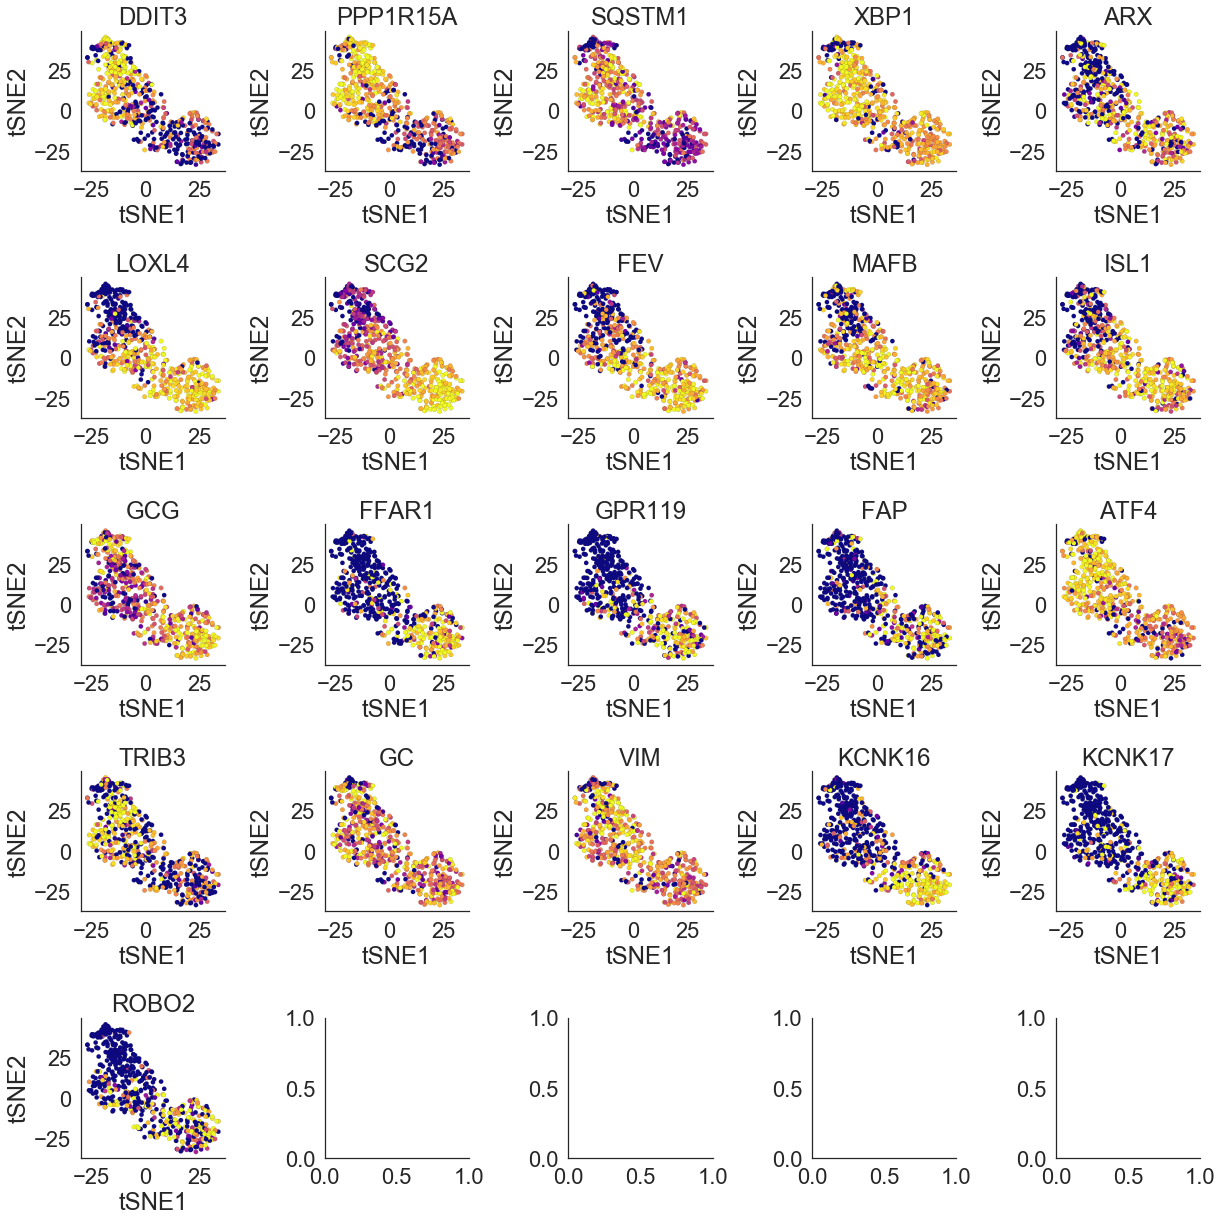

In [20]:
sns.set(font_scale=2)
#nicer plotting style
filter_condition = {'cell_type': ['alpha'], 
                    'DiabetesStatus': ['healthy','T2D'],
                   'Patched': ['Yes'],#,
                   'TimefromDispersion_days': [1,2,3,4],
                   'Glucose_mM': [1,5,10]}#,
                  # 'Glucose_mM': [1,5,10]}
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)

ts = filtered_dataset

pars =['Cell size', 'Peak Na+ current', 'Late Ca2+ current', 'Total Exocitosis','Early exocytosis','Late exocytosis',
        'Early Ca2+ current','Late Ca2+ Conductance','Reversal potential','Na+ conductance']
#col_plot ='Total Exocitosis'
#remova nan, make positive and clip on 95 quantilie, then log
gene_list = ['DDIT3','PPP1R15A','SQSTM1','XBP1','ARX','LOXL4','SCG2','FEV','MAFB','ISL1','GCG','FFAR1','GPR119','FAP','ATF4',
             'TRIB3','GC','VIM','KCNK16','KCNK17','ROBO2']
for par in pars:
    s1 = np.nan_to_num(np.abs(ts.samplesheet[par]))
    clip_val = np.percentile(s1, q=95)
    s1 = np.clip(s1,0,clip_val)
    ts.samplesheet[par+'log'] = np.log(s1+0.5)

ts.counts = ts.counts.loc[gene_list,:] 
ts.counts.dropna(inplace=True)
dims = pos_tsne.reindex(ts.samplesheet.index)

#cut values extreme in expression
clip_min = ts.counts.quantile(q=0.1,axis=1)
clip_max = ts.counts.quantile(q=0.9,axis=1)
ts.counts = ts.counts.clip(clip_min,clip_max,axis=0)


import matplotlib.cm as cm
new_cmap = shiftedColorMap(cm.get_cmap('Blues'), start=0.0, midpoint=0.6, stop=1, name='shrunk')
sns.set_style('white')
#plot log quantile cut parameters
n_cols=5
n_rows=int(len(pars)/n_cols+1)
fig3, axs3 = plt.subplots(n_rows,n_cols, figsize=(3.5*n_cols,3.5*n_rows))
axs3= axs3.flatten()
for i,par in enumerate(pars):
    ts.plot.scatter_reduced_samples(dims,color_by=par+'log', ax=axs3[i], title=par[0:10], cmap=new_cmap,lw=0.1,edgecolor='k',
                                   s=20)
    axs3[i].grid(False)
sns.despine()
fig3.savefig(fig_folder +'/fig6e_suppfig11a_ephys.pdf')
n_cols=5
n_rows=int(len(ts.counts.index.values)/n_cols+1)
#plot genes
fig, axs = plt.subplots(n_rows,n_cols, figsize=(3.5*n_cols,3.5*n_rows))
axs= axs.flatten()
for i,gene in enumerate(ts.counts.index.values):
    axs[i] = ts.plot.scatter_reduced_samples(dims,color_by=gene, ax=axs[i], title=gene, cmap='plasma', lw=0.1,edgecolor='k',
                                            s=20)
    axs[i].grid(False)
sns.despine()
fig.savefig(fig_folder +'fig6e_suppfig6a_genes.pdf')

#### Supp Fig 6 B

In [21]:
filter_condition = {'cell_type': ['alpha'], 
                    'DiabetesStatus': ['healthy','T2D'],
                   'Patched': ['Yes'],
                    'Glucose_mM': [1,5,10],
                    'TimefromDispersion_days': [1,2,3,4],
                              'preincubation': ['No','Yes']}


filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)
#where to output figures and plot names
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
filtered_dataset.samplesheet.Sex = le.fit_transform(filtered_dataset.samplesheet.Sex)


In [22]:
ephys_dict= {'Size': ['Cell size'],
             'Conditions': ['Body mass index (BMI):','Glycated hemoglobin (HbA1c)','Glucose_mM','TimefromDispersion_days'],
         'Exocytosis': ['Total Exocitosis','Early exocytosis','Late exocytosis','Exocytosis norm Ca2+'],#'Total Exocitosis',
         'Calcium channels': ['Ca2+ entry','Early Ca2+ current','Late Ca2+ current','Late Ca2+ Conductance'],#,'Reversal potential'
         'Sodium channels'  : ['Peak Na+ current','Na+ conductance'],#,#,
               'Conditions': ['Glucose_mM','TimefromDispersion_days'],#,
               'Donor': ['Body mass index (BMI):','Glycated hemoglobin (HbA1c)','Age','Sex']}
ephys_list = []
for key, par in ephys_dict.items():
    ephys_list = ephys_list + par
    

#Calculate correlation
df = filtered_dataset.samplesheet[ephys_list].copy()
#df = df[~(df==0)]
df = df.corr(method='spearman', min_periods=1) #calculate correlation matrix on samples
#keep absolute values and make a copy to label with non signed values
df_wabs = df.copy()
df = df.abs()

#make tags
def make_group_tags(df, dict_groups):
    '''df: pandas Dataframe with columns that are found as elements in the dictionart dict_groups (genes)
    dict_groups: dictionary where keys are group (metabolism) and elements are lists of elements (genes)'''
    s = df.copy()
    genes = []
    for key, par in dict_groups.items():
        genes = genes + par

    ds_genetag = pd.DataFrame(index=s.index)
    for group, genes in dict_groups.items():
        for gene in genes:
            if gene in ds_genetag.index:
                ds_genetag.loc[gene,'group'] = group
    ds_genetag = ds_genetag[ds_genetag['group'].notnull()]

    n_groups =ds_genetag['group'].unique().shape[0]
    palette_col = sns.husl_palette(n_groups,s=0.7)
    lut_gene = dict(zip(ds_genetag['group'].unique(), palette_col))
    return lut_gene

lut_gene = make_group_tags(df=df, dict_groups=ephys_dict)

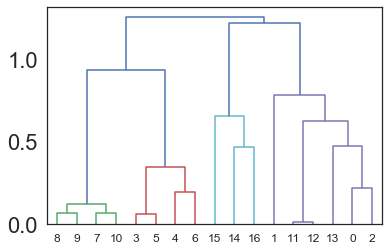

In [23]:
#code to modify ordering of last clustering to make small plots consistent
from scipy.cluster import hierarchy
z = hierarchy.linkage(df, method='average', metric='correlation', optimal_ordering=False)
z2 = hierarchy.dendrogram(z)
reordered_index = z2['leaves']

#name in plotting
ds_genetag = pd.DataFrame(index=df.index)
for group, genes in ephys_dict.items():
    for gene in genes:
        if gene in ds_genetag.index:
            ds_genetag.loc[gene,'group'] = group
ds_genetag = ds_genetag[ds_genetag['group'].notnull()]

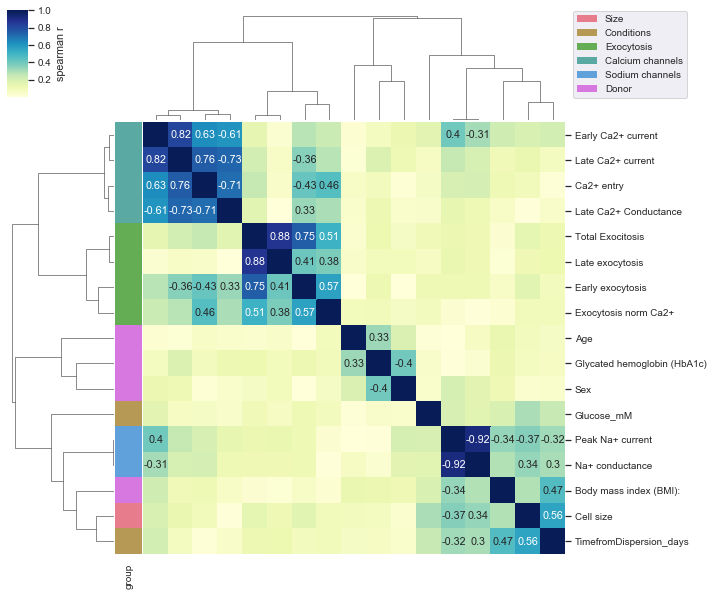

In [24]:
#Do ploting with colouring of one column
#Needs to be called twice
#z = hierarchy.linkage(df, method='average', metric='correlation', optimal_ordering=False)
sns.set(font_scale=0.9) 
#make legend
legend_plot = [mpatches.Patch(color=lut_gene[key], label=key) for key in lut_gene]
#add values onny on values higher than 0,3
annot= df_wabs[(df>0.3) & (df<1)].round(2).astype(str).replace({'nan':''})
annot = annot.iloc[reordered_index, reordered_index]

#plot
g =sns.clustermap(data=df,
                  row_linkage=z,
                  col_linkage=z,
               row_colors=ds_genetag['group'].map(lut_gene) , 
                   yticklabels=1,
               cmap='YlGnBu',
                 metric='correlation',
                 annot=annot,fmt = '',
                 xticklabels='',
                 cbar_kws={'label':'spearman r'})

#labels for gene groups
for key, color in lut_gene.items():
    g.ax_col_dendrogram.bar(0, 0, color=lut_gene[key],
                            label=key, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="right", ncol=1, bbox_to_anchor=(1.3,0.6))
#g.savefig(folder_output_figs + plots_ID +'_spearmanr_par.png',dpi=300)
g.savefig(fig_folder +'suppfig6b_genes.pdf')